In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sentence_transformers import SentenceTransformer

from sklearn.datasets import make_blobs

/opt/anaconda3/envs/tdk_szakdoga/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
categories = ["sci.space", "rec.sport.hockey", "comp.graphics", "talk.politics.mideast"]
newsgroups = fetch_20newsgroups(subset="train", categories=categories, remove=("headers", "footers", "quotes"))

In [3]:
docs = newsgroups.data
labels = newsgroups.target

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(docs, show_progress_bar=True, convert_to_numpy=True)

Batches: 100%|██████████| 74/74 [00:09<00:00,  7.61it/s]


In [5]:
kmeans = KMeans(n_clusters=len(categories), random_state=42, n_init="auto")
kmeans_labels = kmeans.fit_predict(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
dbscan = DBSCAN(eps=0.1, min_samples=5, metric="cosine")
dbscan_labels = dbscan.fit_predict(embeddings)

In [8]:
def evaluate_clustering(true_labels, pred_labels, method):
    mask = pred_labels != -1  # DBSCAN may assign -1 (noise)
    if np.sum(mask) == 0:
        print(f"{method}: all points noise!")
        return
    ari = adjusted_rand_score(np.array(true_labels)[mask], pred_labels[mask])
    nmi = normalized_mutual_info_score(np.array(true_labels)[mask], pred_labels[mask])
    print(f"{method} → ARI: {ari:.3f}, NMI: {nmi:.3f}, Coverage: {np.mean(mask):.2f}")

evaluate_clustering(labels, kmeans_labels, "KMeans")
evaluate_clustering(labels, dbscan_labels, "DBSCAN")

KMeans → ARI: 0.685, NMI: 0.684, Coverage: 1.00
DBSCAN → ARI: 0.000, NMI: 0.000, Coverage: 0.03


In [9]:
np.unique(dbscan_labels)

array([-1,  0])

# v0 online kmeans

In [6]:
# ---------- 1. Generate synthetic dataset ----------
X, y_true = make_blobs(n_samples=1000, centers=4, cluster_std=0.6, random_state=42)

In [7]:
# ---------- 2. Online KMeans class ----------
class OnlineKMeans:
    def __init__(self, n_clusters=4, learning_rate=0.5, random_state=None):
        self.n_clusters = n_clusters
        self.learning_rate = learning_rate
        self.random_state = np.random.RandomState(random_state)
        self.centroids = None

    def initialize_centroids(self, X):
        idx = self.random_state.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[idx]

    def partial_fit(self, X_batch):
        if self.centroids is None:
            self.initialize_centroids(X_batch)

        for x in X_batch:
            # assign to nearest centroid
            distances = np.linalg.norm(self.centroids - x, axis=1)
            k = np.argmin(distances)
            # update centroid with learning rate
            self.centroids[k] = (1 - self.learning_rate) * self.centroids[k] + self.learning_rate * x

    def predict(self, X):
        distances = np.linalg.norm(self.centroids[None, :, :] - X[:, None, :], axis=2)
        return np.argmin(distances, axis=1)

In [8]:
# ---------- 3. Train normal KMeans ----------
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
y_kmeans = kmeans.fit_predict(X)

In [9]:
# ---------- 4. Train Online KMeans ----------
online = OnlineKMeans(n_clusters=4, learning_rate=0.3, random_state=42)

# simulate streaming in small batches
batch_size = 20
for i in range(0, len(X), batch_size):
    online.partial_fit(X[i:i+batch_size])

y_online = online.predict(X)

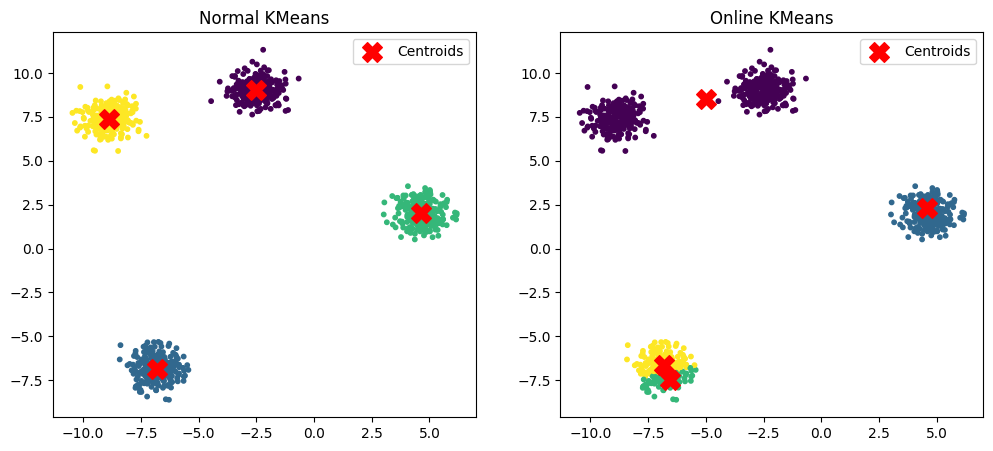

In [10]:
# ---------- 5. Visualization ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Normal KMeans
axs[0].scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap="viridis", s=10)
axs[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c="red", marker="X", s=200, label="Centroids")
axs[0].set_title("Normal KMeans")
axs[0].legend()

# Online KMeans
axs[1].scatter(X[:, 0], X[:, 1], c=y_online, cmap="viridis", s=10)
axs[1].scatter(online.centroids[:, 0], online.centroids[:, 1],
               c="red", marker="X", s=200, label="Centroids")
axs[1].set_title("Online KMeans")
axs[1].legend()

plt.show()

# v1 online kmeans

In [3]:
class OnlineKMeansImproved:
    def __init__(
        self,
        n_clusters=4,
        max_clusters=20,
        metric="euclidean",   # "euclidean" or "cosine"
        new_cluster_threshold=None, # if None, no dynamic creation
        merge_threshold=None,  # if not None, merge centroids closer than this
        decay=1.0,             # multiply counts by this factor periodically (<=1.0)
        random_state=None,
    ):
        self.n_clusters = n_clusters
        self.max_clusters = max_clusters
        self.metric = metric
        self.new_cluster_threshold = new_cluster_threshold
        self.merge_threshold = merge_threshold
        self.decay = decay
        self.rng = np.random.RandomState(random_state)

        self.centroids = None     # (k, d)
        self.counts = None        # (k,)
        self.sums = None          # (k, d) running sums (optional convenience)
        self.vars = None          # per-cluster variance estimate (scalar)
        self.total_seen = 0

    def _normalize(self, X):
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        return X / norms

    def _pairwise_dist(self, X, C):
        # returns (n_points, n_centroids) distances
        if self.metric == "euclidean":
            # squared distance then sqrt
            d2 = np.sum((X[:, None, :] - C[None, :, :]) ** 2, axis=2)
            return np.sqrt(d2 + 1e-12)
        else:  # cosine distance = 1 - dot(normalized)
            Xn = self._normalize(X)
            Cn = self._normalize(C)
            return 1.0 - (Xn @ Cn.T)

    def _kmeans_pp_init(self, X, k):
        # returns k centers chosen from X (indices) by kmeans++
        n = X.shape[0]
        centers = []
        first = self.rng.randint(0, n)
        centers.append(first)
        d2 = np.full(n, np.inf)
        for _ in range(1, k):
            cur = X[centers[-1 :], :]
            dist = np.sum((X - cur) ** 2, axis=1)
            d2 = np.minimum(d2, dist)
            probs = d2 / (d2.sum() + 1e-12)
            next_idx = self.rng.choice(n, p=probs)
            centers.append(int(next_idx))
        return np.array(centers, dtype=int)

    def initialize_centroids(self, X_init):
        # initialize centroids using kmeans++ on X_init (or random fallback)
        k = self.n_clusters
        if X_init.shape[0] < k:
            # fallback: random pick with replacement
            idx = self.rng.choice(len(X_init), k, replace=True)
            centers = X_init[idx]
        else:
            idx = self._kmeans_pp_init(X_init, k)
            centers = X_init[idx]
        if self.metric == "cosine":
            centers = self._normalize(centers)
        self.centroids = centers.copy()
        self.counts = np.zeros(len(self.centroids), dtype=float)
        self.sums = np.zeros_like(self.centroids)
        self.vars = np.zeros(len(self.centroids), dtype=float)
        self.total_seen = 0

    def partial_fit(self, X_batch):
        """
        Vectorized minibatch update:
         - assign points to nearest centroid
         - for each cluster, compute batch sum and batch count
         - do exact incremental mean update using counts
        Also can create new clusters for far-away points (optional).
        """
        X = np.asarray(X_batch, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        if self.metric == "cosine":
            X = self._normalize(X)

        if self.centroids is None:
            # init from first batch
            self.initialize_centroids(X)
            # if we used kmeans++ the centroids are populated but counts=0

        # compute pairwise distances
        D = self._pairwise_dist(X, self.centroids)
        min_dist = D.min(axis=1)
        labels = D.argmin(axis=1)

        # dynamic creation of new clusters for far-away points
        if (self.new_cluster_threshold is not None) and (len(self.centroids) < self.max_clusters):
            far_idx = np.where(min_dist > self.new_cluster_threshold)[0]
            # create up to capacity new clusters from these points
            to_create = min(len(far_idx), self.max_clusters - len(self.centroids))
            for j in range(to_create):
                i = far_idx[j]
                new_center = X[i].copy()
                if self.metric == "cosine":
                    new_center = self._normalize(new_center.reshape(1, -1))[0]
                # append new centroid
                self.centroids = np.vstack([self.centroids, new_center])
                self.counts = np.concatenate([self.counts, np.array([0.0])])
                self.sums = np.vstack([self.sums, np.zeros_like(new_center)])
                self.vars = np.concatenate([self.vars, np.array([0.0])])
                # reassign label of this point to the new cluster
                labels[i] = len(self.centroids) - 1

            # recompute distances/labels if centers changed (safe)
            D = self._pairwise_dist(X, self.centroids)
            min_dist = D.min(axis=1)
            labels = D.argmin(axis=1)

        # vectorized update: for each cluster compute batch_sum and m
        k_now = len(self.centroids)
        for k in range(k_now):
            mask = labels == k
            m = mask.sum()
            if m == 0:
                continue
            batch_points = X[mask]
            batch_sum = batch_points.sum(axis=0)
            batch_mean = batch_sum / m

            # incremental mean update using counts
            n_old = self.counts[k]
            if n_old == 0:
                # pure initialization for this cluster
                self.centroids[k] = batch_mean
                self.counts[k] = m
                self.sums[k] = batch_sum
                # compute variance (scalar average squared distance)
                diffs = batch_points - batch_mean
                self.vars[k] = np.mean(np.sum(diffs ** 2, axis=1))
            else:
                new_count = n_old + m
                # update centroid to combined mean:
                new_centroid = (n_old * self.centroids[k] + batch_sum) / new_count
                # update variance with combined formula:
                # var_new = (n_old*(var_old + (mu_old - mu_new)^2) + m*(var_batch + (mu_batch-mu_new)^2)) / new_count
                var_old = self.vars[k]
                mu_old = self.centroids[k]
                mu_batch = batch_mean
                # batch variance
                diffs = batch_points - mu_batch
                var_batch = np.mean(np.sum(diffs ** 2, axis=1))
                delta_old = mu_old - new_centroid
                delta_batch = mu_batch - new_centroid
                var_new = (n_old * (var_old + np.sum(delta_old ** 2)) + m * (var_batch + np.sum(delta_batch ** 2))) / new_count

                # commit updates
                self.centroids[k] = new_centroid
                self.counts[k] = new_count
                self.sums[k] += batch_sum
                self.vars[k] = var_new

        self.total_seen += len(X)

        # renormalize centroids for cosine
        if self.metric == "cosine":
            self.centroids = self._normalize(self.centroids)

        # optional: merge very close clusters
        if (self.merge_threshold is not None) and (len(self.centroids) > 1):
            self._merge_close_clusters()

    def _merge_close_clusters(self):
        # merges centroids that are closer than merge_threshold
        C = self.centroids
        k = len(C)
        D = self._pairwise_dist(C, C)  # symmetric
        np.fill_diagonal(D, np.inf)
        merge_pairs = np.argwhere(D < self.merge_threshold)
        if len(merge_pairs) == 0:
            return
        to_remove = set()
        for i, j in merge_pairs:
            if i in to_remove or j in to_remove:
                continue
            # merge j into i (weighted)
            n_i = self.counts[i]
            n_j = self.counts[j]
            total = n_i + n_j if (n_i + n_j) > 0 else 1.0
            new_centroid = (n_i * self.centroids[i] + n_j * self.centroids[j]) / total
            self.centroids[i] = new_centroid
            # update counts, sums, variance
            self.counts[i] = total
            self.sums[i] = self.sums[i] + self.sums[j]
            self.vars[i] = (self.vars[i] + self.vars[j]) / 2.0
            to_remove.add(j)
        if to_remove:
            keep = [idx for idx in range(len(self.centroids)) if idx not in to_remove]
            self.centroids = self.centroids[keep]
            self.counts = self.counts[keep]
            self.sums = self.sums[keep]
            self.vars = self.vars[keep]

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if self.metric == "cosine":
            X = self._normalize(X)
        D = self._pairwise_dist(X, self.centroids)
        return D.argmin(axis=1)

    def get_state(self):
        return {
            "centroids": self.centroids.copy(),
            "counts": self.counts.copy(),
            "vars": self.vars.copy(),
            "total_seen": self.total_seen,
        }

Batch KMeans ARI: 1.000
Online Improved ARI: 1.000


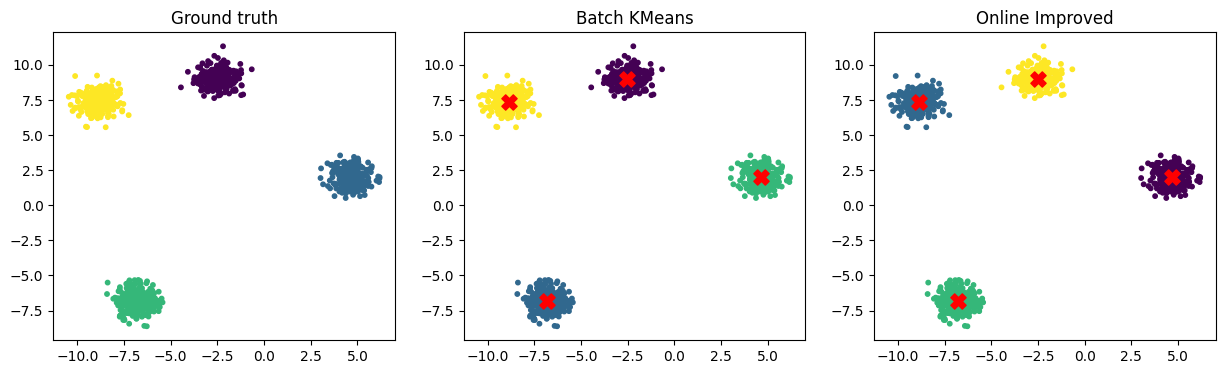

In [4]:
# generate data
X, y_true = make_blobs(n_samples=1000, centers=4, cluster_std=0.6, random_state=42, n_features=2)

# batch KMeans reference
kmeans_batch = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)
y_batch = kmeans_batch.labels_

# online improved
online = OnlineKMeansImproved(
    n_clusters=4,
    max_clusters=10,
    metric="euclidean",
    new_cluster_threshold=2.0,  # empirical; tune
    merge_threshold=1.7,        # tune if desired
    random_state=42,
)

# simulate streaming in minibatches
batch_size = 25
for i in range(0, len(X), batch_size):
    batch = X[i : i + batch_size]
    online.partial_fit(batch)

y_online = online.predict(X)

# Evaluate ARI
ari_batch = adjusted_rand_score(y_true, y_batch)
ari_online = adjusted_rand_score(y_true, y_online)
print(f"Batch KMeans ARI: {ari_batch:.3f}")
print(f"Online Improved ARI: {ari_online:.3f}")

# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].scatter(X[:, 0], X[:, 1], c=y_true, s=10); axs[0].set_title("Ground truth")
axs[1].scatter(X[:, 0], X[:, 1], c=y_batch, s=10)
axs[1].scatter(kmeans_batch.cluster_centers_[:,0], kmeans_batch.cluster_centers_[:,1], c='red', s=120, marker='X'); axs[1].set_title("Batch KMeans")
axs[2].scatter(X[:, 0], X[:, 1], c=y_online, s=10)
cent = online.centroids
axs[2].scatter(cent[:,0], cent[:,1], c='red', s=120, marker='X'); axs[2].set_title("Online Improved")
plt.show()

Batch KMeans ARI: 0.961
Online Improved ARI: 0.944


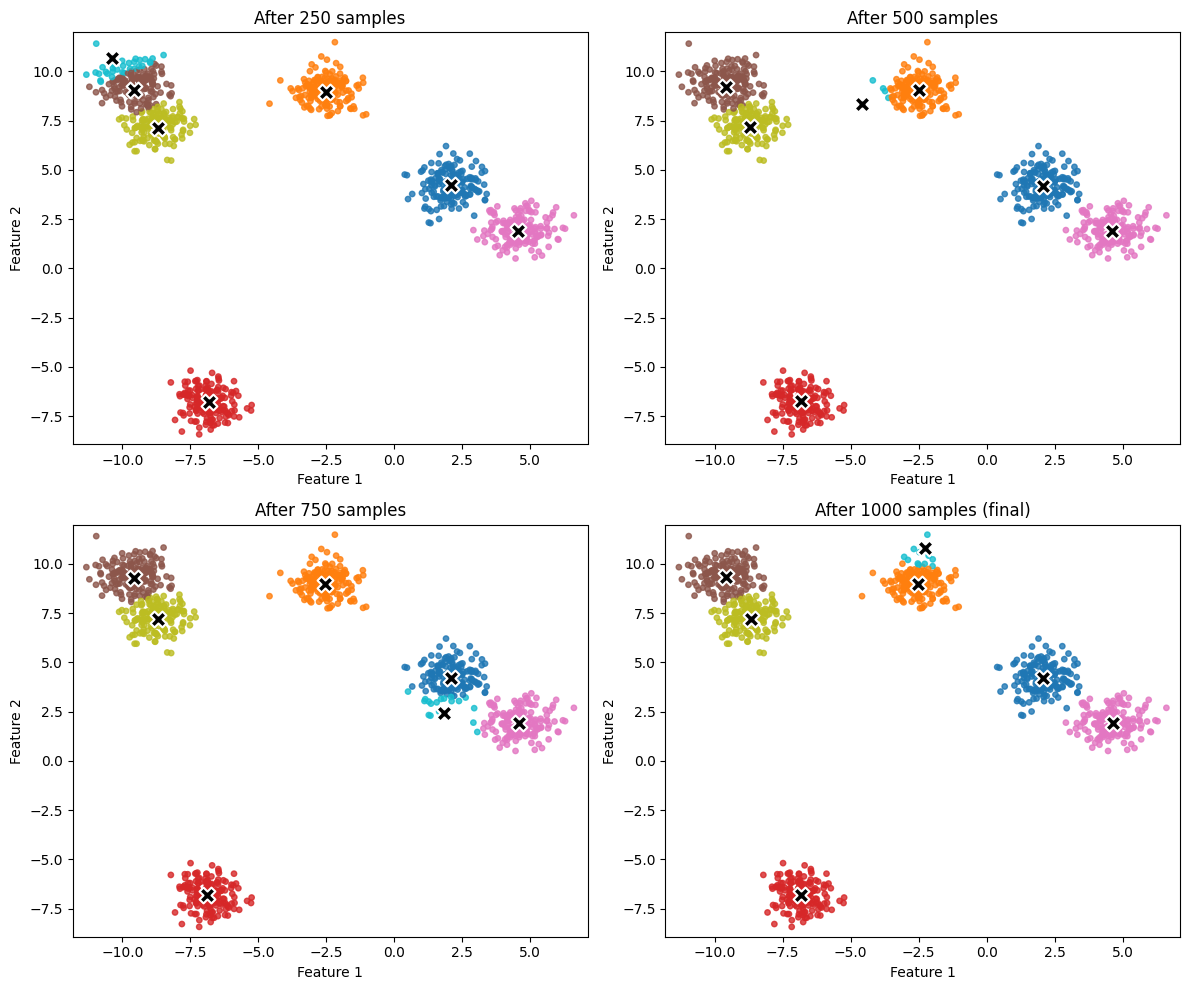

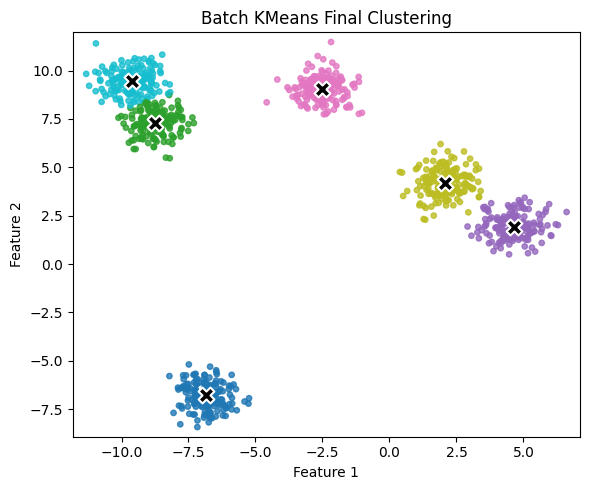

In [5]:
# ---- Generate data ----
X, y_true = make_blobs(
    n_samples=1000, centers=6, cluster_std=0.64,
    random_state=42, n_features=2
)

# ---- Batch KMeans reference ----
kmeans_batch = KMeans(n_clusters=6, random_state=42, n_init=10).fit(X)
y_batch = kmeans_batch.labels_

# ---- Online KMeans Improved (assumed defined elsewhere) ----
online = OnlineKMeansImproved(
    n_clusters=4,
    max_clusters=10,
    metric="euclidean",
    new_cluster_threshold=2.0,
    merge_threshold=1.7,
    random_state=42,
)

# ---- Stream simulation ----
batch_size = 25
snapshots = []

# exact quarter checkpoints for 1000 samples
checkpoints = [250, 500, 750, 1000]
captured = set()
samples_seen = 0

for i in range(0, len(X), batch_size):
    batch = X[i : i + batch_size]
    online.partial_fit(batch)
    samples_seen += len(batch)

    # capture snapshot when we reach or pass a checkpoint
    for cp in checkpoints:
        if samples_seen >= cp and cp not in captured:
            labels_now = online.predict(X)
            snapshots.append((cp, np.copy(online.centroids), labels_now))
            captured.add(cp)

# Ensure chronological order
snapshots.sort(key=lambda t: t[0])

# ---- Evaluate ----
_, _, labels_final = snapshots[-1]
ari_batch = adjusted_rand_score(y_true, y_batch)
ari_online = adjusted_rand_score(y_true, labels_final)
print(f"Batch KMeans ARI: {ari_batch:.3f}")
print(f"Online Improved ARI: {ari_online:.3f}")

# ---- Plot 1: Online KMeans evolution (2x2 grid) ----
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

titles = [
    f"After {snapshots[0][0]} samples",
    f"After {snapshots[1][0]} samples",
    f"After {snapshots[2][0]} samples",
    f"After {snapshots[3][0]} samples (final)",
]

for ax, (step, centroids, labels_now), title in zip(axs, snapshots, titles):
    ax.scatter(X[:, 0], X[:, 1], c=labels_now, s=15, alpha=0.8, cmap='tab10')
    ax.scatter(
        centroids[:, 0], centroids[:, 1],
        c='black', s=130, marker='X',
        edgecolors='white', linewidths=1.5
    )
    ax.set_title(title)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# ---- Plot 2: Batch KMeans final state ----
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_batch, s=15, alpha=0.8, cmap='tab10')
plt.scatter(
    kmeans_batch.cluster_centers_[:, 0],
    kmeans_batch.cluster_centers_[:, 1],
    c='black', s=130, marker='X',
    edgecolors='white', linewidths=1.5
)
plt.title("Batch KMeans Final Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.tight_layout()
plt.show()


Batch KMeans ARI: 0.961
Online Improved ARI: 0.944


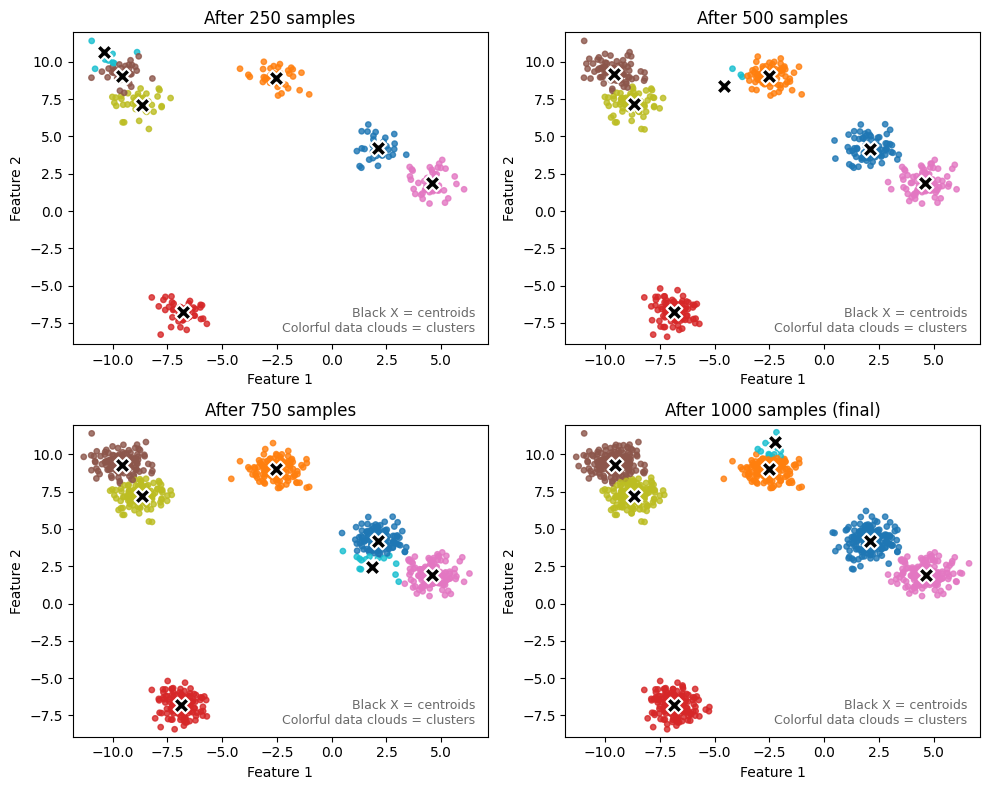

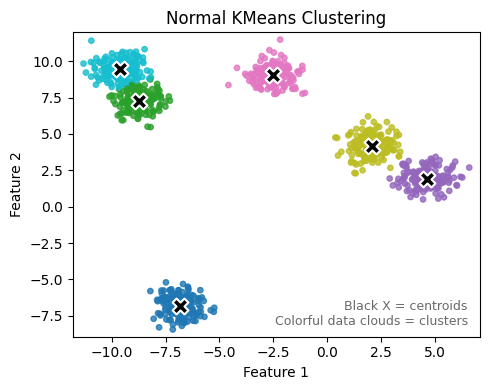

In [7]:
# ---- Generate data ----
X, y_true = make_blobs(
    n_samples=1000, centers=6, cluster_std=0.64,
    random_state=42, n_features=2
)

# ---- Batch KMeans reference ----
kmeans_batch = KMeans(n_clusters=6, random_state=42, n_init=10).fit(X)
y_batch = kmeans_batch.labels_

# ---- Online KMeans Improved (your implementation) ----
online = OnlineKMeansImproved(
    n_clusters=4,
    max_clusters=10,
    metric="euclidean",
    new_cluster_threshold=2.0,
    merge_threshold=1.7,
    random_state=42,
)

# ---- Stream simulation ----
batch_size = 25
snapshots = []

# exact quarter checkpoints for 1000 samples
checkpoints = [250, 500, 750, 1000]
captured = set()
samples_seen = 0

for i in range(0, len(X), batch_size):
    batch = X[i : i + batch_size]
    online.partial_fit(batch)
    samples_seen += len(batch)

    # capture snapshot when we reach or pass a checkpoint
    for cp in checkpoints:
        if samples_seen >= cp and cp not in captured:
            labels_now = online.predict(X)
            snapshots.append((cp, np.copy(online.centroids), labels_now))
            captured.add(cp)

# ---- Evaluate ----
_, _, labels_final = snapshots[-1]
ari_batch = adjusted_rand_score(y_true, y_batch)
ari_online = adjusted_rand_score(y_true, labels_final)
print(f"Batch KMeans ARI: {ari_batch:.3f}")
print(f"Online Improved ARI: {ari_online:.3f}")

# ---- Plot 1: Online KMeans evolution (2x2 grid) ----
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

titles = [
    f"After {snapshots[0][0]} samples",
    f"After {snapshots[1][0]} samples",
    f"After {snapshots[2][0]} samples",
    f"After {snapshots[3][0]} samples (final)",
]

for ax, (step, centroids, labels_now), title in zip(axs, snapshots, titles):
    # only plot the samples that have been processed so far
    X_seen = X[:step]
    labels_seen = labels_now[:step]

    ax.scatter(X_seen[:, 0], X_seen[:, 1], c=labels_seen, s=15, alpha=0.8, cmap='tab10')
    ax.scatter(
        centroids[:, 0], centroids[:, 1],
        c='black', s=130, marker='X',
        edgecolors='white', linewidths=1.5
    )
    ax.set_title(title)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.text(
        0.97, 0.03,
        "Black X = centroids\nColorful data clouds = clusters",
        transform=ax.transAxes,
        fontsize=9,
        color="dimgray",
        ha="right", va="bottom",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=3)
    )

plt.tight_layout()
plt.savefig("./plots/online_clustering_flow/online_clustering_flow.png", dpi=300)
plt.show()

# ---- Plot 2: Batch KMeans final state ----
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], c=y_batch, s=15, alpha=0.8, cmap='tab10')
plt.scatter(
    kmeans_batch.cluster_centers_[:, 0],
    kmeans_batch.cluster_centers_[:, 1],
    c='black', s=130, marker='X',
    edgecolors='white', linewidths=1.5
)
plt.title("Normal KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.text(
    0.97, 0.03,
    "Black X = centroids\nColorful data clouds = clusters",
    transform=plt.gca().transAxes,
    fontsize=9,
    color="dimgray",
    ha="right", va="bottom",
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=3)
)
plt.tight_layout()
plt.savefig("./plots/online_clustering_flow/batch_kmeans.png", dpi=300)
plt.show()
